In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
  # %tensorflow_version only exists in colab, thats why we using colab again.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print ("TF version:", tf.__version__)
print ("Hub version:", hub.__version__)
print ("GPU is", "available" if tf.test.is_gpu_available() else "Not Available")

TF version: 2.8.0
Hub version: 0.12.0
GPU is Not Available


In [ ]:
print ("GPU is", "available" if tf.test.is_gpu_available() else "Not Available")

GPU is Not Available


In [ ]:
import numpy as np
from keras.models import Model
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
import cv2
import matplotlib.pyplot as plt
from keras.layers import Input, Lambda, Dense, Flatten

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
train_path= '/content/drive/MyDrive/SkinDiseases/train'
test_path= '/content/drive/MyDrive/SkinDiseases/test'

In [ ]:
vgg = ResNet50(input_shape=IMAGE_SIZE +[3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
    layer.trainable=False

In [ ]:
folders = glob('/content/drive/MyDrive/SkinDiseases/train/*')

In [ ]:
x= Flatten()(vgg.output)
x= Dense(64, activation= 'relu')(x)
prediction = Dense(11, activation='softmax')(x)

In [ ]:
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen =ImageDataGenerator(rescale = 1./255,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/SkinDiseases/train',
                                                target_size=(224, 224),
                                                batch_size= 32,
                                                class_mode='categorical')
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/SkinDiseases/test',
                                           target_size= (224, 224),
                                           batch_size = 32,
                                           class_mode = 'categorical')

Found 10859 images belonging to 11 classes.
Found 1561 images belonging to 11 classes.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
r= model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=2,
    steps_per_epoch=100,
    validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/2
100/100 [==============================] - 891s 9s/step - loss: 2.3540 - accuracy: 0.2271 - val_loss: 2.3344 - val_accuracy: 0.2306
Epoch 2/2
100/100 [==============================] - 863s 9s/step - loss: 2.3429 - accuracy: 0.2103 - val_loss: 2.3146 - val_accuracy: 0.2306


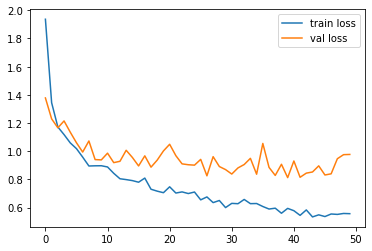

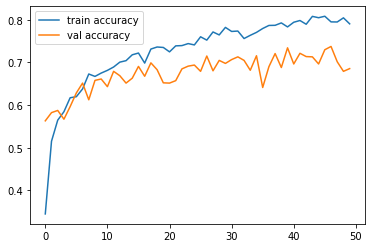

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [ ]:
saved_model_path = "saved_model/SkinDisease"
!mkdir -p saved_model
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: saved_model/SkinDisease/assets


INFO:tensorflow:Assets written to: saved_model/SkinDisease/assets


In [ ]:
!mkdir "tflite_model"
TFLITE_MODEL = "tflite_model/SkinDisease.tflite"

In [ ]:
model = tf.saved_model.load(saved_model_path)
concrete_func = model.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 224, 224, 3])

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

65295728